# Getting Started

In this notebook we will get you started with the *easiest* way to use `matvis` directly.
We will learn how to set up the various parameters required, and plot the outputs. 

Note that there are two main ways to use `matvis`: the low-level API is considered to be the 
"algorithm" and defines the interface that all implementations must expose. There are 
*two* such implementations in this package (`matvis_cpu` and `matvis_gpu`). Here, we will use
the *high-level* "wrapper" API, which is provided as a convenience and "example" of how
to use `matvis`. In practice, using this high-level API should typically be sufficient.

<div class="alert alert-info">
    
Note
   
The absolute easiest way to use `matvis` is via the `hera_sim` [plugin interface](https://hera-sim.readthedocs.io/en/latest/tutorials/hera_sim_vis_cli.html).
</div>

<div class="alert alert-warning">

Warning

Before running this tutorial, you should make sure you understand the basic concepts
and algorithm that `matvis` uses. You can read up on that [here](../understanding_the_algorithm.html)
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import EarthLocation

from matvis import conversions, simulate_vis
from pyuvsim.analyticbeam import AnalyticBeam

## Setup Telescope / Observation Parameters

We need a few input parameters to setup our observation: antenna positions, beam models,
and a sky model. 

Here we will set up a very simple observation for introductory purposes. 

First, create our antenna positions. We define this as a dictionary, which maps an 
antenna number to its 3D East-North-Up position relative to the array centre. We define
just three antennas, in a right-angle triangle with side length 14m.

In [2]:
ants = {
    0: (0, 0, 0),
    1: (14, 0, 0),
    2: (0, 14, 0)
}

Now, let's define the beams for each of these antennas. `matvis` allows us to specify
different beams for each antenna, but we need only specify *unique* beams. Each beam
must be either a `UVBeam` or `AnalyticBeam`. Here, for simplicity we just use the 
`AnalyticBeam` class. We do this as follows:

In [3]:
beams = [AnalyticBeam("gaussian", sigma=0.5), AnalyticBeam("uniform")]
beam_idx = [0, 0, 1]

Here, we specified two unique beams for three antennas. The `beam_idx` tells each antenna
which beam to use. Thus antenna 0 and 1 will use the Gaussian beam, while antenna 2 will
use the uniform beam.

We also need to tell `matvis` the observational configuration, such as the frequency
channels and times to use. In this example, we don't worry too much about the exact date
of observation, but rather the LST. In general, the exact date of observation does make
a little difference.

First, let's define our frequency channels:

In [4]:
# Frequencies in Hz
Nfreqs = 10
freqs = np.linspace(1e8 , 1.2e8, Nfreqs)

In [5]:
# LSTs in radians
Ntimes = 20
lsts = np.linspace( np.pi / 1.5, np.pi / 1.3, Ntimes)

## Setup Sky Model

`matvis` makes the "point source approximation" -- that is, it breaks the sky into a 
series of sources that it sums over. This is an approximation for a diffuse sky model,
but is exact for a point-source sky. In this introduction, let us assume a simple point
source sky with just two sources.

In [6]:
nsource = 2

ra = np.deg2rad(np.linspace(0. , 30., nsource))        # ra of each source (in rad)
dec = np.deg2rad(np.linspace(-25. , -35., nsource))    # dec of each source (in rad)
flux = np.ones(nsource)                                # flux of each source at 100MHz (in Jy)
sp_index = np.ones(nsource) * -0.8                     # sp. index of each source

# Now get the (Nsource, Nfreq) array of the flux of each source at each frequency.
flux_allfreq = ((freqs[:, np.newaxis] / freqs[0]) ** sp_index.T * flux.T).T

### Correct source locations to a given date.

Internally, `matvis` uses simple rigid-rotation of the equatorial coordinates to transform
the sources into topocentric coordinates (i.e. alt/az). This is an approximation that ignores
precession and nutation of the Earth's rotation. To mitigate the error arising from this
assumption, we can "correct" the input RA/DEC coordinates so that the sources are accurate
at a certain time.

To do this, we need the position of the telescope, and also the time at which we want
the coordinates to be exact (typically the start or midpoint of the observation).

In [7]:
hera_lon = 21.428305555555557
hera_lat = -30.72152777777791
hera_height = 1073.0000000093132

location = EarthLocation.from_geodetic(lat=hera_lat, lon=hera_lon, height=hera_height)

In [8]:
obstime = Time("2018-08-31T04:02:30.11", format="isot", scale="utc")

ra_new, dec_new = conversions.equatorial_to_eci_coords(
    ra, dec, obstime, location, unit="rad", frame="icrs"
)

## Run matvis

Now that we've setup all our parameters, we can easily run the simulation using the 
high-level wrapper API. Along with the configuration we've already defined, the 
`simulate_vis` wrapper takes a few extra options. One of the most important is 
`polarized`: if true, then full polarized visibilities are returned (with shape
`(nfreqs, ntimes, nfeed, nfeed, nants, nants)`), otherwise, unpolarized visibilities
are returned (with shape `(nfreqs, ntimes, nants, nants)`). In our case, the 
`AnalyticBeam` objects we're using don't support polarization, so we set this to false.

We can also set the `precision` parameter, which switches between 32-bit (if `precision=1`)
and 64-bit (if `precision=2`) floating precision. 

In [9]:
# simulate visibilities 
vis_vc = simulate_vis(
        ants=ants,
        fluxes=flux_allfreq,
        ra=ra_new,
        dec=dec_new,
        freqs=freqs,
        lsts=lsts,
        beams=beams,
        beam_idx=np.array(beam_idx),
        polarized=False,
        precision=2,
    )

In [10]:
vis_vc.shape

(10, 20, 3, 3)

# Plot auto and cross visibilities

Here, we plot the visibility amplitude and phase as a function of frequency and LSTs. For auto-correlation (e.g. antenna pair (0,0)) we expect the phase would be zero. Here, the amplitude is constant with frequency as we assumed the spectral of the sources are zero.

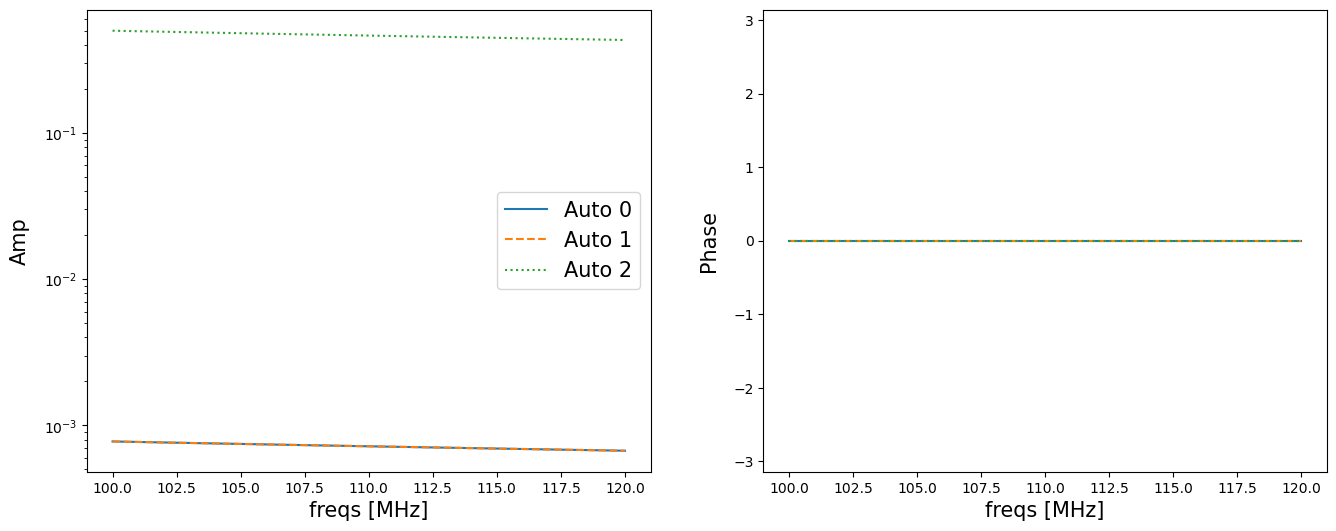

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for ant in range(3):
    ax[0].plot(freqs/1.e6, np.abs(vis_vc[:,0,ant, ant]), ls=['-', '--', ':'][ant], label=rf'Auto {ant}')
    ax[0].set_ylabel('Amp', fontsize=15,labelpad=10)
    ax[0].set_xlabel(r'freqs [MHz]', fontsize=15)
    ax[0].set_yscale('log')
    ax[0].legend(fontsize=15)


    ax[1].plot(freqs/1.e6, np.angle(vis_vc[:,0,ant, ant]), ls=['-', '--', ':'][ant])
    ax[1].set_ylabel('Phase', fontsize=15,labelpad=10)
    ax[1].set_xlabel(r'freqs [MHz]', fontsize=15)
    ax[1].set_ylim(-np.pi, np.pi)

plt.show()

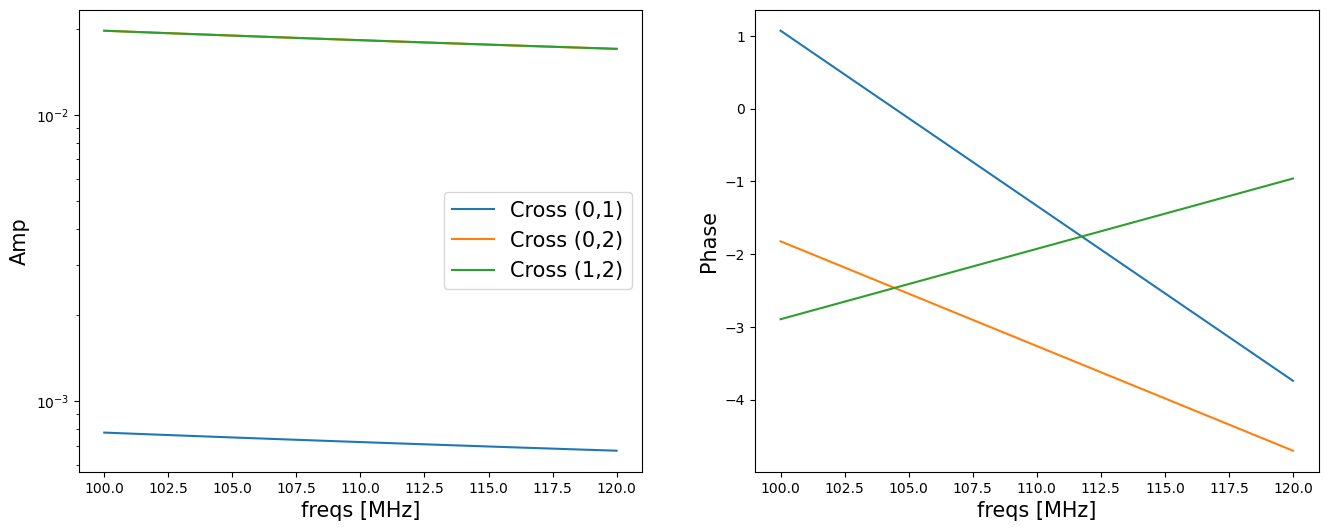

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for ant1 in range(3):
    for ant2 in range(ant1+1, 3):
        ax[0].plot(freqs/1.e6, np.abs(vis_vc[:,0,ant1,ant2]), label=rf'Cross ({ant1},{ant2})')
        ax[0].set_ylabel('Amp', fontsize=15)
        ax[0].set_xlabel(r'freqs [MHz]', fontsize=15)
        ax[0].set_yscale('log')
        ax[0].legend(fontsize=15)


        ax[1].plot(freqs/1.e6, np.unwrap(np.angle(vis_vc[:,0,ant1,ant2])))
        ax[1].set_ylabel('Phase', fontsize=15)
        ax[1].set_xlabel(r'freqs [MHz]', fontsize=15)

plt.show()

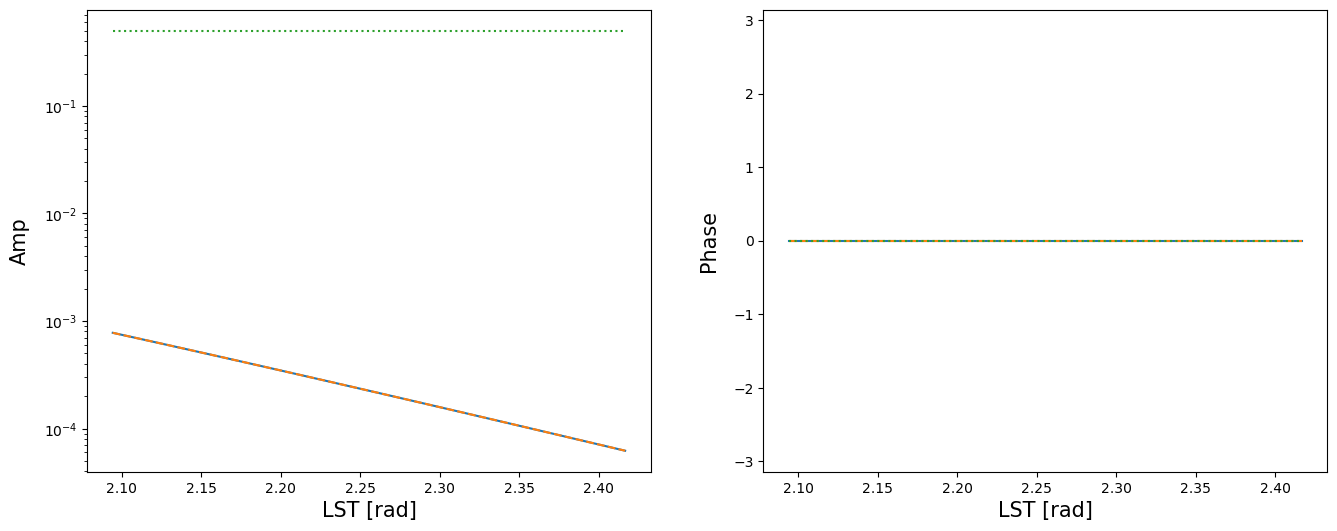

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for ant in range(3):
    ax[0].plot(lsts, np.abs(vis_vc[0,:,ant, ant]), ls=['-', '--', ':'][ant], label=rf'Auto {ant}')
    ax[0].set_ylabel('Amp', fontsize=15,labelpad=10)
    ax[0].set_xlabel(r'LST [rad]', fontsize=15)
    ax[0].set_yscale('log')

    ax[1].plot(lsts, np.angle(vis_vc[0,:,ant, ant]), ls=['-', '--', ':'][ant])
    ax[1].set_ylabel('Phase', fontsize=15,labelpad=10)
    ax[1].set_xlabel(r'LST [rad]', fontsize=15)
    ax[1].set_ylim(-np.pi, np.pi)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


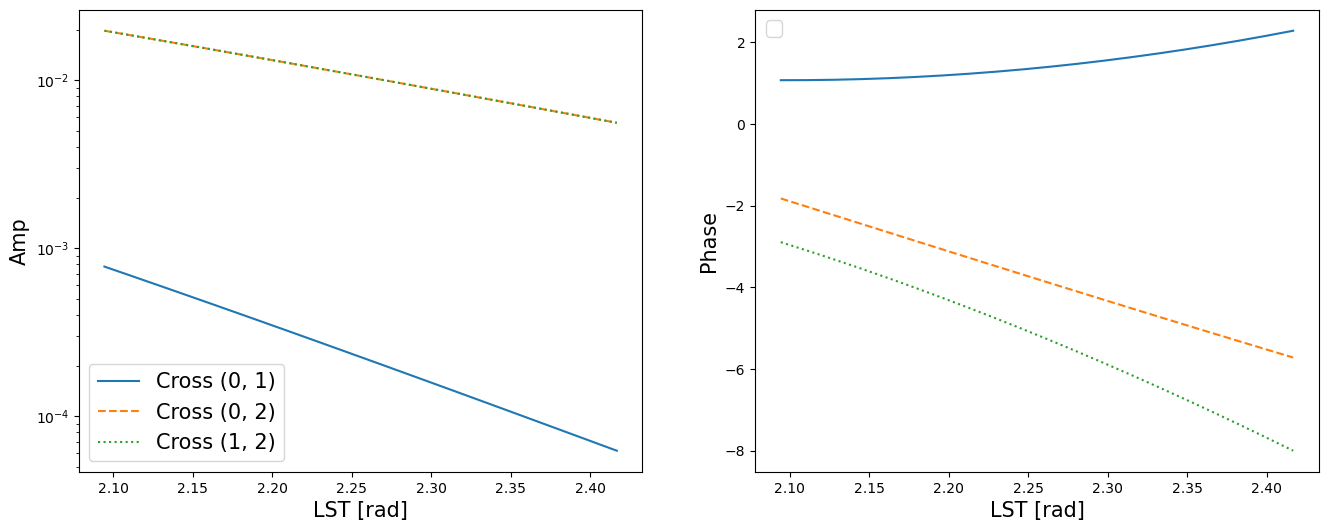

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for ant1 in range(3):
    for ant2 in range(ant1+1, 3):
        ls = ['-', '--', ':'][ant1+ant2 - 1]
        ax[0].plot(lsts, np.abs(vis_vc[0,:,ant1,ant2]), label=rf'Cross ({ant1}, {ant2})',ls=ls)
        ax[0].set_ylabel('Amp', fontsize=15)
        ax[0].set_xlabel(r'LST [rad]', fontsize=15)
        ax[0].set_yscale('log')
        ax[0].legend(fontsize=15)



        ax[1].plot(lsts, np.unwrap(np.angle(vis_vc[0,:,ant1, ant2])),ls=ls)
        ax[1].set_ylabel('Phase', fontsize=15)
        ax[1].set_xlabel(r'LST [rad]', fontsize=15)
        ax[1].legend(fontsize=15)

plt.show()